# ML1 - HW3 (Loan Prediction) - Tommy Wang

## Set UP

In [1]:
!pip install lightgbm catboost

In [2]:
import pandas as pd
import numpy as np
import joblib
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

In [9]:
# Load datasets
metadata_path = "Metadata.csv"
raw_data_path = "Data for Cleaning _ Modeling.csv"
holdout_path = "Holdout for Testing.csv"

metadata_df = pd.read_csv(metadata_path, encoding="latin1")
raw_data_df = pd.read_csv(raw_data_path, encoding="latin1")
holdout_df = pd.read_csv(holdout_path, encoding="latin1")

/var/folders/2v/n_jhx9gs4xs5dd88y0zh33n00000gn/T/ipykernel_46846/4132918797.py:7: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data_df = pd.read_csv(raw_data_path, encoding="latin1")


## EDA

In [10]:
# Create DataFrame with column metadata
column_info_df = pd.DataFrame({
    "Column Name": raw_data_df.columns,
    "Missing Values": raw_data_df.isna().sum().values,
    "Unique Values": raw_data_df.nunique().values,
    "Data Type": raw_data_df.dtypes.values,
    "Definition": metadata_df.set_index("Variable").loc[raw_data_df.columns, "Definition"].values
})
column_info_df

,Column Name,Missing Values,Unique Values,Data Type,Definition
0,X1,61010,482,object,Interest Rate on the loan
1,X2,1,399999,float64,A unique id for the loan.
2,X3,1,399999,float64,A unique id assigned for the borrower.
3,X4,1,1339,object,Loan amount requested
4,X5,1,1342,object,Loan amount funded
5,X6,1,7036,object,Investor-funded portion of loan
6,X7,1,2,object,Number of payments (36 or 60)
7,X8,61270,7,object,Loan grade
8,X9,61270,35,object,Loan subgrade
9,X10,23986,187821,object,Employer or job title (self-filled)


## Cleaning

In [11]:
# Data Cleaning Function
def clean_data(df, is_holdout=False):
    df = df.copy()
    
    # Drop unnecessary columns
    cols_to_drop = ["X2", "X3", "X10", "X16", "X18", "X19", "X25", "X26"]
    df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
    
    # Drop columns with excessive missing values
    cols_with_many_nans = ["X8", "X9", "X12", "X16", "X25", "X26"]
    df.drop(columns=cols_with_many_nans, inplace=True, errors='ignore')
    
    # Drop rows where the target variable (X1) is missing, unless it's holdout data
    if not is_holdout:
        df = df.dropna(subset=['X1'])
    
    # Drop rows that are completely empty or missing most values
    df = df.dropna(thresh=int(0.5 * len(df.columns)))
    
    # Convert percentage and currency columns to numeric
    for col in ["X1", "X4", "X5", "X6", "X30"]:
        df[col] = df[col].replace({'%': '', '\$': '', ',': ''}, regex=True).astype(float)
    
    # Convert date columns to datetime format
    df["X15"] = pd.to_datetime(df["X15"], format='%b-%y', errors='coerce')
    df["X23"] = pd.to_datetime(df["X23"], format='%b-%y', errors='coerce')
    
    # Impute categorical variables with the most frequent value
    categorical_cols = ["X7", "X11", "X13", "X14", "X17", "X20", "X32"]
    df[categorical_cols] = df[categorical_cols].apply(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))
    
    # Impute numerical variables with the median
    numerical_cols = ["X21", "X22", "X24", "X27", "X28", "X29", "X30","X31"]
    df[numerical_cols] = df[numerical_cols].apply(lambda x: x.fillna(x.median()))
    
    # Drop rows where essential columns are missing
    essential_cols = ["X7", "X14"]
    df = df.dropna(subset=essential_cols)
    
    # Remove X1 from holdout data
    if is_holdout:
        df = df.drop(columns=['X1'], errors='ignore')
    
    return df

In [12]:
# clean training data
df_cleaned = clean_data(raw_data_df)
df_cleaned.head()

,X1,X4,X5,X6,X7,X11,X13,X14,X15,X17,X20,X21,X22,X23,X24,X27,X28,X29,X30,X31,X32
0,11.89,25000.0,25000.0,19080.0,36 months,< 1 year,85000.0,VERIFIED - income,2009-08-01,debt_consolidation,CA,19.48,0.0,1994-02-01,0.0,10.0,0.0,28854.0,52.1,42.0,f
1,10.71,7000.0,7000.0,673.0,36 months,< 1 year,65000.0,not verified,2008-05-01,credit_card,NY,14.29,0.0,2000-10-01,0.0,7.0,0.0,33623.0,76.7,7.0,f
2,16.99,25000.0,25000.0,24725.0,36 months,1 year,70000.0,VERIFIED - income,2014-08-01,debt_consolidation,NY,10.50,0.0,2000-06-01,0.0,10.0,0.0,19878.0,66.3,17.0,f
3,13.11,1200.0,1200.0,1200.0,36 months,10+ years,54000.0,not verified,2010-03-01,debt_consolidation,TX,5.47,0.0,1985-01-01,0.0,5.0,0.0,2584.0,40.4,31.0,f
4,13.57,10800.0,10800.0,10692.0,36 months,6 years,32000.0,not verified,2009-11-01,debt_consolidation,CT,11.63,0.0,1996-12-01,1.0,14.0,0.0,3511.0,25.6,40.0,f


## Feature Engineering

In [13]:
# Feature Engineering Function
def feature_engineering(df):
    df = df.copy()
    
    # Encode categorical variables
    label_encoder = LabelEncoder()
    for col in df.select_dtypes(include=['object']).columns:
        if df[col].nunique() == 2:
            df[col] = label_encoder.fit_transform(df[col])
        else:
            df[col] = df[col].astype('category').cat.codes
    
    # Create a new feature: Days between the two date columns
    df["Days_Between_X15_X23"] = (df["X15"] - df["X23"]).dt.days.fillna(0).astype(float)
    
    # Create interaction feature: Ratio of funded amount to requested amount
    df["Funded_to_Requested_Ratio"] = df["X5"] / df["X4"]
    
    # Create interaction feature: Loan burden relative to income
    df["Loan_to_Income_Ratio"] = df["X4"] / df["X13"]

    # Create combined credit lines feature while handling division by zero
    df["Active_Credit_Line_Ratio"] = df["X31"] / df["X27"].replace(0, np.nan)
    df["Active_Credit_Line_Ratio"] = df["Active_Credit_Line_Ratio"].fillna(0)
    
    # Drop the original date columns and highly correlated one
    df.drop(columns=["X5", "X6", "X15", "X23", "X27"], inplace=True, errors='ignore')

    
    return df

In [14]:
df_engineered = feature_engineering(df_cleaned)
df_engineered.head()

,X1,X4,X7,X11,X13,X14,X17,X20,X21,X22,X24,X28,X29,X30,X31,X32,Days_Between_X15_X23,Funded_to_Requested_Ratio,Loan_to_Income_Ratio,Active_Credit_Line_Ratio
0,11.89,25000.0,0,10,85000.0,0,2,4,19.48,0.0,0.0,0.0,28854.0,52.1,42.0,0,5660.0,1.0,0.294118,4.200000
1,10.71,7000.0,0,10,65000.0,2,1,33,14.29,0.0,0.0,0.0,33623.0,76.7,7.0,0,2769.0,1.0,0.107692,1.000000
2,16.99,25000.0,0,0,70000.0,0,2,33,10.50,0.0,0.0,0.0,19878.0,66.3,17.0,0,5174.0,1.0,0.357143,1.700000
3,13.11,1200.0,0,1,54000.0,2,2,42,5.47,0.0,0.0,0.0,2584.0,40.4,31.0,0,9190.0,1.0,0.022222,6.200000
4,13.57,10800.0,0,6,32000.0,2,2,6,11.63,0.0,1.0,0.0,3511.0,25.6,40.0,0,4718.0,1.0,0.337500,2.857143


## Standardization

In [15]:
# Standardization Function
def standardize_data(df):
    df = df.copy()
    scaler = StandardScaler()
    
    # Identify continuous numerical columns (excluding categorical ones)
    categorical_cols = df.select_dtypes(include=['int8', 'int64']).columns
    numerical_cols = [col for col in df.columns if col not in categorical_cols and col != "X1"]
    
    # Apply StandardScaler to numerical columns
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    
    return df

In [16]:
df_standardized = standardize_data(df_engineered)
df_standardized.head()

,X1,X4,X7,X11,X13,X14,X17,X20,X21,X22,X24,X28,X29,X30,X31,X32,Days_Between_X15_X23,Funded_to_Requested_Ratio,Loan_to_Income_Ratio,Active_Credit_Line_Ratio
0,11.89,1.299407,0,10,0.266781,0,2,4,0.322553,-0.351968,-0.772152,-0.302138,0.651635,-0.177510,1.483838,0,-0.011038,0.064756,0.633471,1.782349
1,10.71,-0.881816,0,10,-0.118288,2,1,33,-0.351717,-0.351968,-0.772152,-0.302138,0.892918,0.858443,-1.567229,0,-1.020979,0.064756,-0.985025,-1.348237
2,16.99,1.299407,0,0,-0.022021,0,2,33,-0.844103,-0.351968,-0.772152,-0.302138,0.197502,0.420479,-0.695496,0,-0.180817,0.064756,1.180639,-0.663421
3,13.11,-1.584655,0,1,-0.330075,2,2,42,-1.497587,-0.351968,-0.772152,-0.302138,-0.677473,-0.670220,0.524931,0,1.222131,0.064756,-1.727053,3.738965
4,13.57,-0.421336,0,6,-0.753650,2,2,6,-0.697297,-0.351968,0.171901,-0.302138,-0.630572,-1.293477,1.309491,0,-0.340116,0.064756,1.010105,0.468621


## XGB

In [34]:
# Hyperparameter tuning for XGBoost
def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
    }
    model = XGBRegressor(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    return -score

xgb_study = optuna.create_study(direction='minimize')
xgb_study.optimize(objective_xgb, n_trials=30)
best_xgb_params = xgb_study.best_params
xgb_best = XGBRegressor(**best_xgb_params, random_state=42)
xgb_best.fit(X_train, y_train)
y_pred_xgb = xgb_best.predict(X_val)
xgb_rmse = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
xgb_model_filename = "XGBoost_Finetuned.pkl"
joblib.dump(xgb_best, xgb_model_filename)

[I 2025-02-17 23:29:20,841] A new study created in memory with name: no-name-f4c75a2b-6867-4113-b793-ee3b0579c8f4
[I 2025-02-17 23:29:36,585] Trial 0 finished with value: 3.1586761462036366 and parameters: {'n_estimators': 67, 'max_depth': 15, 'learning_rate': 0.2915672192903674}. Best is trial 0 with value: 3.1586761462036366.
[I 2025-02-17 23:29:38,166] Trial 1 finished with value: 2.9536158756494926 and parameters: {'n_estimators': 53, 'max_depth': 8, 'learning_rate': 0.16390501229297968}. Best is trial 1 with value: 2.9536158756494926.
[I 2025-02-17 23:29:53,469] Trial 2 finished with value: 3.1732161274328896 and parameters: {'n_estimators': 90, 'max_depth': 13, 'learning_rate': 0.014529842790687782}. Best is trial 1 with value: 2.9536158756494926.
[I 2025-02-17 23:29:58,889] Trial 3 finished with value: 3.0040556531455023 and parameters: {'n_estimators': 187, 'max_depth': 9, 'learning_rate': 0.25268124901368394}. Best is trial 1 with value: 2.9536158756494926.
[I 2025-02-17 23:29

['XGBoost_Finetuned.pkl']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [23]:
import joblib
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# Load best hyperparameters from tuning
best_xgb_params = joblib.load("XGBoost_Finetuned.pkl").get_xgb_params()
best_xgb_params.pop('random_state', None)

# Retrain the best XGBoost model on the full training set
xgb_final = XGBRegressor(**best_xgb_params, random_state=42)
xgb_final.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb_test = xgb_final.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb_test)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb_test)
r2_xgb = r2_score(y_test, y_pred_xgb_test)

# Print the evaluation metrics
print(f"Test MSE: {mse_xgb:.4f}")
print(f"Test RMSE: {rmse_xgb:.4f}")
print(f"Test MAE: {mae_xgb:.4f}")
print(f"Test R²: {r2_xgb:.4f}")

# Save the final trained model
joblib.dump(xgb_final, "XGBoost_Final.pkl")


Test MSE: 8.5098
Test RMSE: 2.9171
Test MAE: 2.2930
Test R²: 0.5544


['XGBoost_Final.pkl']

### Random Forest

In [28]:
import joblib
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the saved Random Forest model hyperparameters
rf_final = RandomForestRegressor(n_estimators=100, random_state=42)
rf_final.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_final.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print evaluation metrics
print(f"Random Forest Regressor Final Evaluation:")
print(f"Test MSE: {mse_rf:.4f}")
print(f"Test RMSE: {rmse_rf:.4f}")
print(f"Test MAE: {mae_rf:.4f}")
print(f"Test R²: {r2_rf:.4f}")


Random Forest Regressor Final Evaluation:
Test MSE: 9.0811
Test RMSE: 3.0135
Test MAE: 2.3690
Test R²: 0.5245


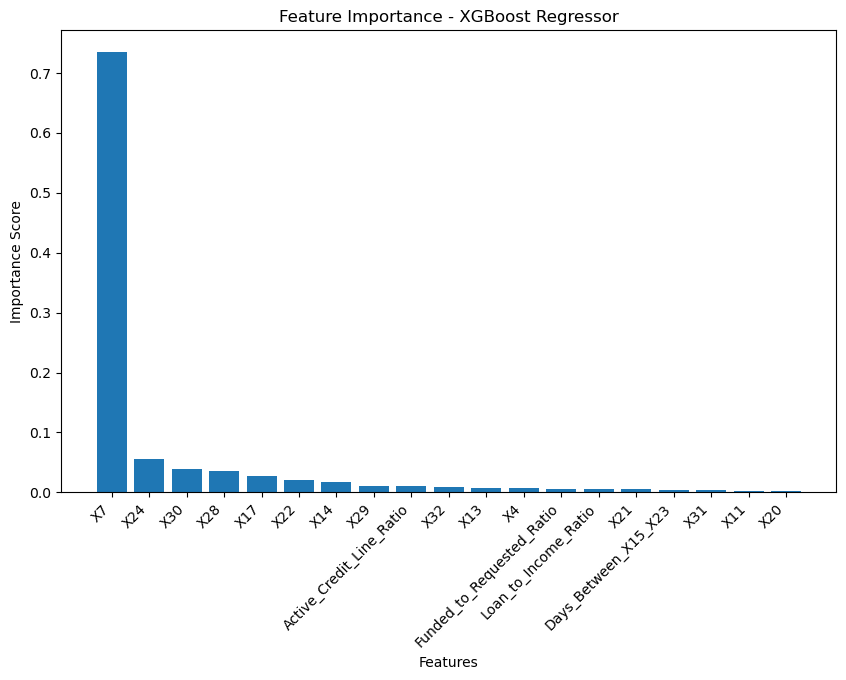

X7: 0.7346
X24: 0.0548
X30: 0.0382
X28: 0.0359
X17: 0.0271
X22: 0.0210
X14: 0.0167
X29: 0.0098
Active_Credit_Line_Ratio: 0.0097
X32: 0.0090
X13: 0.0078
X4: 0.0076
Funded_to_Requested_Ratio: 0.0060
Loan_to_Income_Ratio: 0.0054
X21: 0.0050
Days_Between_X15_X23: 0.0040
X31: 0.0038
X11: 0.0019
X20: 0.0017


In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance scores
feature_importances = xgb_final.feature_importances_

# Get feature names (if X_train is a DataFrame)
if hasattr(X_train, "columns"):
    feature_names = X_train.columns
else:
    feature_names = [f"Feature {i}" for i in range(X_train.shape[1])]

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align="center")
plt.xticks(range(len(feature_importances)), np.array(feature_names)[sorted_indices], rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Feature Importance - XGBoost Regressor")
plt.show()

# Print feature importances in descending order
for i in sorted_indices:
    print(f"{feature_names[i]}: {feature_importances[i]:.4f}")


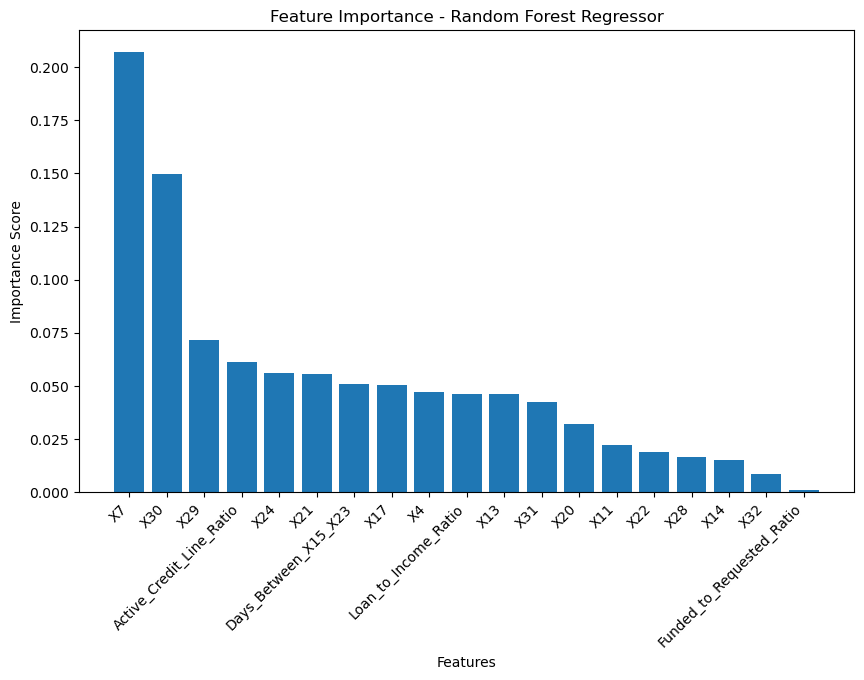

X7: 0.2070
X30: 0.1498
X29: 0.0718
Active_Credit_Line_Ratio: 0.0614
X24: 0.0559
X21: 0.0557
Days_Between_X15_X23: 0.0511
X17: 0.0506
X4: 0.0471
Loan_to_Income_Ratio: 0.0462
X13: 0.0461
X31: 0.0423
X20: 0.0323
X11: 0.0221
X22: 0.0190
X28: 0.0166
X14: 0.0154
X32: 0.0084
Funded_to_Requested_Ratio: 0.0012


In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance scores
feature_importances = rf_final.feature_importances_

# Get feature names (if X_train is a DataFrame)
if hasattr(X_train, "columns"):
    feature_names = X_train.columns
else:
    feature_names = [f"Feature {i}" for i in range(X_train.shape[1])]

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align="center")
plt.xticks(range(len(feature_importances)), np.array(feature_names)[sorted_indices], rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Feature Importance - Random Forest Regressor")
plt.show()

# Print feature importances in descending order
for i in sorted_indices:
    print(f"{feature_names[i]}: {feature_importances[i]:.4f}")
